# DNN Baseline for Aftershock Prediction (Binary Classification)

**Course:** SE4050 - Deep Learning  
**Assignment:** Deep Learning Project  

## Objective
Train Dense Neural Network (DNN) baselines for **aftershock triggering prediction** to compare against GNN models.

**Purpose**: This notebook demonstrates the value of graph structure by showing that:
- DNNs use only node features (28 engineered features per earthquake)
- GNNs use node features + graph structure (spatial/temporal relationships)
- **Expected**: GNNs should outperform DNNs by 10-15% in F1 score

## Models Tested
1. **Shallow DNN** - 2 hidden layers (baseline)
2. **Standard DNN** - 3 hidden layers (main baseline)
3. **Deep DNN** - 5 hidden layers with residual connections (complex baseline)

## Task Definition
**Binary Classification**: Predict whether an earthquake will trigger at least one aftershock within:
- **7 days** after the event
- **50 km** radius from the event

## Dataset
- **Source:** Same as GNN models (processed earthquake features)
- **Features:** 28 engineered features (spatial, temporal, seismic activity)
- **Target:** Binary (0=no aftershocks, 1=triggers aftershocks)
- **No graph structure** - only tabular features

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
sys.path.append('..')

# Import DNN models
from models.dnn import AftershockDNN
from models.dnn.aftershock_dnn import AftershockDNN_Shallow, AftershockDNN_Deep

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")

# Create directories
os.makedirs('../results/models/dnn_aftershock', exist_ok=True)
os.makedirs('../results/visualizations/dnn_aftershock', exist_ok=True)

print("\n✓ Setup complete")

Device: cpu
PyTorch version: 2.8.0+cpu

✓ Setup complete


## Load Data (Same Features as GNN, No Graph Structure)

We use the same processed earthquake features as GNNs, but without the graph edges.

In [2]:
print("Loading aftershock data (tabular format)...")

# Load the same data that GNNs use
data_dict = np.load('../data/processed/model_ready/gnn_data_aftershock.npy', allow_pickle=True).item()

# Extract features and labels
X = data_dict['x']  # Node features (28 features per earthquake)
y = data_dict['y']  # Binary labels (0 or 1)

# Extract train/val/test masks
train_mask = data_dict['train_mask']
val_mask = data_dict['val_mask']
test_mask = data_dict['test_mask']

# Split data
X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

print(f"\nData Statistics:")
print(f"  Features: {X.shape[1]}")
print(f"  Total samples: {len(X):,}")
print(f"  Train: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Val:   {len(X_val):,} ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test:  {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")

print(f"\nClass Distribution:")
print(f"  Overall: {y.sum():,} positive ({y.mean()*100:.1f}%)")
print(f"  Train: {y_train.sum():,} positive ({y_train.mean()*100:.1f}%)")
print(f"  Val: {y_val.sum():,} positive ({y_val.mean()*100:.1f}%)")
print(f"  Test: {y_test.sum():,} positive ({y_test.mean()*100:.1f}%)")

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

# Create data loaders
batch_size = 128

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\n✓ Data loaded successfully")
print(f"  Batch size: {batch_size}")
print(f"  Train batches: {len(train_loader)}")

Loading aftershock data (tabular format)...

Data Statistics:
  Features: 28
  Total samples: 5,727
  Train: 4,008 (70.0%)
  Val:   859 (15.0%)
  Test:  860 (15.0%)

Class Distribution:
  Overall: 3,090 positive (54.0%)
  Train: 2,107 positive (52.6%)
  Val: 536 positive (62.4%)
  Test: 447 positive (52.0%)

✓ Data loaded successfully
  Batch size: 128
  Train batches: 32


## Training Functions for DNN Models

In [3]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)


def evaluate(model, data_loader, criterion, device):
    """Evaluate model with binary classification metrics."""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item()
            
            # Predictions and probabilities
            predictions = outputs.argmax(dim=1).cpu().numpy()
            probs = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            
            all_predictions.extend(predictions)
            all_targets.extend(batch_y.cpu().numpy())
            all_probs.extend(probs)
    
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, zero_division=0)
    recall = recall_score(all_targets, all_predictions, zero_division=0)
    f1 = f1_score(all_targets, all_predictions, zero_division=0)
    
    try:
        roc_auc = roc_auc_score(all_targets, all_probs)
    except:
        roc_auc = 0.0
    
    return {
        'loss': total_loss / len(data_loader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'predictions': all_predictions,
        'targets': all_targets,
        'probabilities': all_probs
    }


def train_model(model, train_loader, val_loader, num_epochs=150, lr=0.001, 
                patience=20, model_name='DNN'):
    """Complete training loop with early stopping."""
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-5)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=7, min_lr=1e-5
    )
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_f1': [],
        'val_roc_auc': []
    }
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    print(f"\nTraining {model_name}")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_metrics = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_metrics['loss'])
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_metrics['loss'])
        history['val_accuracy'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1'])
        history['val_roc_auc'].append(val_metrics['roc_auc'])
        
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d} | "
                  f"Train Loss: {train_loss:.4f} | "
                  f"Val Loss: {val_metrics['loss']:.4f} | "
                  f"Acc: {val_metrics['accuracy']:.4f} | "
                  f"F1: {val_metrics['f1']:.4f} | "
                  f"ROC-AUC: {val_metrics['roc_auc']:.4f}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    model.load_state_dict(best_model_state)
    print(f"Best validation loss: {best_val_loss:.4f}")
    print("-" * 60)
    
    return model, history


print("✓ Training functions defined")

✓ Training functions defined


## Initialize DNN Models

In [4]:
num_features = X_train.shape[1]

models = {
    'DNN-Shallow': AftershockDNN_Shallow(
        num_features=num_features,
        hidden_dim=64,
        dropout=0.2,
        output_dim=2
    ),
    
    'DNN-Standard': AftershockDNN(
        num_features=num_features,
        hidden_dims=[128, 64, 32],
        dropout=0.3,
        output_dim=2
    ),
    
    'DNN-Deep': AftershockDNN_Deep(
        num_features=num_features,
        hidden_dim=128,
        dropout=0.3,
        output_dim=2
    )
}

print("\nDNN Model Summary:")
print("=" * 60)
for name, model in models.items():
    num_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{name:15s} | Parameters: {num_params:,} (trainable: {trainable_params:,})")
print("=" * 60)


DNN Model Summary:
DNN-Shallow     | Parameters: 4,194 (trainable: 4,194)
DNN-Standard    | Parameters: 14,562 (trainable: 14,562)
DNN-Deep        | Parameters: 58,562 (trainable: 58,562)


## Train All DNN Models

In [5]:
trained_models = {}
histories = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}")
    print(f"{'='*60}")
    
    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=150,
        lr=0.001,
        patience=20,
        model_name=name
    )
    
    trained_models[name] = trained_model
    histories[name] = history
    
    torch.save(trained_model.state_dict(), f'../results/models/dnn_aftershock/{name}_model.pt')
    print(f"✓ Model saved to ../results/models/dnn_aftershock/{name}_model.pt")

print("\n" + "="*60)
print("ALL DNN MODELS TRAINED SUCCESSFULLY")
print("="*60)


Training DNN-Shallow

Training DNN-Shallow
------------------------------------------------------------
Epoch   1 | Train Loss: 0.6798 | Val Loss: 0.3866 | Acc: 0.8184 | F1: 0.8440 | ROC-AUC: 0.8985
Epoch  10 | Train Loss: 0.4438 | Val Loss: 0.3632 | Acc: 0.8277 | F1: 0.8462 | ROC-AUC: 0.9001
Epoch  20 | Train Loss: 0.4263 | Val Loss: 0.3630 | Acc: 0.8254 | F1: 0.8438 | ROC-AUC: 0.9063
Epoch  30 | Train Loss: 0.4170 | Val Loss: 0.3538 | Acc: 0.8300 | F1: 0.8501 | ROC-AUC: 0.9098
Early stopping at epoch 33
Best validation loss: 0.3467
------------------------------------------------------------
✓ Model saved to ../results/models/dnn_aftershock/DNN-Shallow_model.pt

Training DNN-Standard

Training DNN-Standard
------------------------------------------------------------
Epoch   1 | Train Loss: 0.6601 | Val Loss: 0.3686 | Acc: 0.8405 | F1: 0.8580 | ROC-AUC: 0.8975
Epoch  10 | Train Loss: 0.4506 | Val Loss: 0.3436 | Acc: 0.8405 | F1: 0.8586 | ROC-AUC: 0.9078
Epoch  20 | Train Loss: 0.4298

## Test Set Evaluation

In [6]:
print("\n" + "="*70)
print("TEST SET EVALUATION")
print("="*70)

test_results = {}
criterion = nn.CrossEntropyLoss()

for name, model in trained_models.items():
    results = evaluate(model, test_loader, criterion, device)
    test_results[name] = results
    
    print(f"\n{name}:")
    print(f"  Accuracy:  {results['accuracy']:.4f}")
    print(f"  Precision: {results['precision']:.4f}")
    print(f"  Recall:    {results['recall']:.4f}")
    print(f"  F1 Score:  {results['f1']:.4f}")
    print(f"  ROC-AUC:   {results['roc_auc']:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(results['targets'], results['predictions'])
    print(f"  Confusion Matrix:")
    print(f"    TN={cm[0,0]}, FP={cm[0,1]}")
    print(f"    FN={cm[1,0]}, TP={cm[1,1]}")

best_model = max(test_results.keys(), key=lambda k: test_results[k]['f1'])
print(f"\n{'='*70}")
print(f"BEST DNN MODEL: {best_model} (F1: {test_results[best_model]['f1']:.4f})")
print(f"{'='*70}")

# Save results
import pickle
with open('../results/models/dnn_aftershock/test_results.pkl', 'wb') as f:
    pickle.dump(test_results, f)

with open('../results/models/dnn_aftershock/histories.pkl', 'wb') as f:
    pickle.dump(histories, f)

print("\n✓ Results saved")


TEST SET EVALUATION

DNN-Shallow:
  Accuracy:  0.7256
  Precision: 0.9073
  Recall:    0.5257
  F1 Score:  0.6657
  ROC-AUC:   0.8215
  Confusion Matrix:
    TN=389, FP=24
    FN=212, TP=235

DNN-Standard:
  Accuracy:  0.7279
  Precision: 0.9176
  Recall:    0.5235
  F1 Score:  0.6667
  ROC-AUC:   0.8169
  Confusion Matrix:
    TN=392, FP=21
    FN=213, TP=234

DNN-Deep:
  Accuracy:  0.7140
  Precision: 0.9205
  Recall:    0.4922
  F1 Score:  0.6414
  ROC-AUC:   0.8049
  Confusion Matrix:
    TN=394, FP=19
    FN=227, TP=220

BEST DNN MODEL: DNN-Standard (F1: 0.6667)

✓ Results saved


## Visualizations and Comparison with GNN

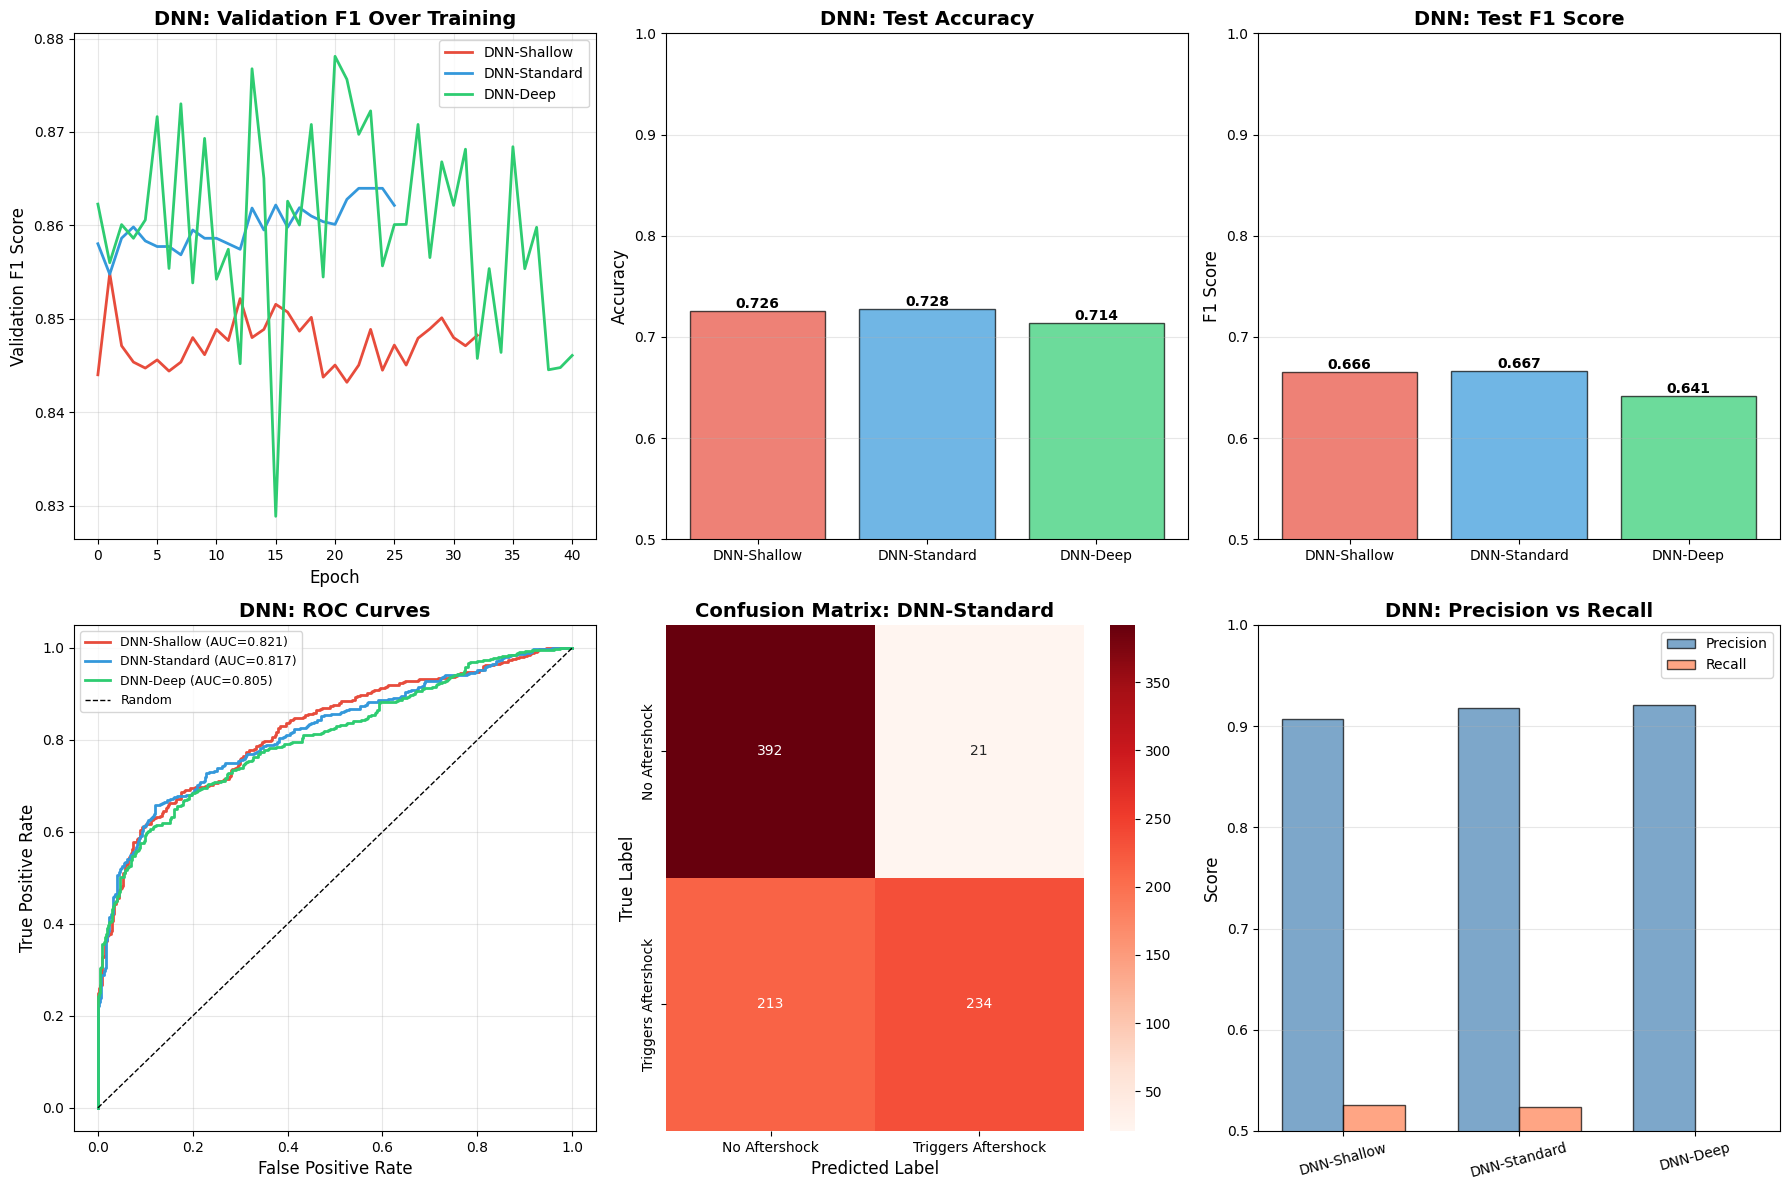


✓ Visualization saved


In [7]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Training curves (F1 score)
ax = axes[0, 0]
colors = ['#e74c3c', '#3498db', '#2ecc71']
for (name, history), color in zip(histories.items(), colors):
    ax.plot(history['val_f1'], label=name, linewidth=2, color=color)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Validation F1 Score', fontsize=12)
ax.set_title('DNN: Validation F1 Over Training', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 2. Test Accuracy comparison
ax = axes[0, 1]
names = list(test_results.keys())
accuracy_values = [test_results[n]['accuracy'] for n in names]
bars = ax.bar(names, accuracy_values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('DNN: Test Accuracy', fontsize=14, fontweight='bold')
ax.set_ylim([0.5, 1.0])
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, accuracy_values):
    ax.text(bar.get_x() + bar.get_width()/2, val, f'{val:.3f}', 
           ha='center', va='bottom', fontweight='bold')

# 3. F1 Score comparison
ax = axes[0, 2]
f1_values = [test_results[n]['f1'] for n in names]
bars = ax.bar(names, f1_values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('DNN: Test F1 Score', fontsize=14, fontweight='bold')
ax.set_ylim([0.5, 1.0])
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, f1_values):
    ax.text(bar.get_x() + bar.get_width()/2, val, f'{val:.3f}', 
           ha='center', va='bottom', fontweight='bold')

# 4. ROC curves
ax = axes[1, 0]
for (name, results), color in zip(test_results.items(), colors):
    fpr, tpr, _ = roc_curve(results['targets'], results['probabilities'])
    ax.plot(fpr, tpr, label=f"{name} (AUC={results['roc_auc']:.3f})", 
           linewidth=2, color=color)
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('DNN: ROC Curves', fontsize=14, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# 5. Confusion matrix (best model)
ax = axes[1, 1]
best_model_name = max(test_results.keys(), key=lambda k: test_results[k]['f1'])
cm = confusion_matrix(test_results[best_model_name]['targets'], 
                     test_results[best_model_name]['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=ax, cbar=True)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title(f'Confusion Matrix: {best_model_name}', fontsize=14, fontweight='bold')
ax.set_xticklabels(['No Aftershock', 'Triggers Aftershock'])
ax.set_yticklabels(['No Aftershock', 'Triggers Aftershock'])

# 6. Precision-Recall comparison
ax = axes[1, 2]
precision_values = [test_results[n]['precision'] for n in names]
recall_values = [test_results[n]['recall'] for n in names]
x = np.arange(len(names))
width = 0.35
bars1 = ax.bar(x - width/2, precision_values, width, label='Precision', 
              alpha=0.7, edgecolor='black', color='steelblue')
bars2 = ax.bar(x + width/2, recall_values, width, label='Recall', 
              alpha=0.7, edgecolor='black', color='coral')
ax.set_ylabel('Score', fontsize=12)
ax.set_title('DNN: Precision vs Recall', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=15)
ax.set_ylim([0.5, 1.0])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/visualizations/dnn_aftershock/model_comparison.png', 
           dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved")

## Final Summary and DNN vs GNN Comparison

In [8]:
print("\n" + "="*70)
print("FINAL SUMMARY - DNN BASELINES")
print("="*70)

# Create summary table
summary_data = []
for name in test_results.keys():
    summary_data.append({
        'Model': name,
        'Type': 'DNN',
        'Accuracy': test_results[name]['accuracy'],
        'Precision': test_results[name]['precision'],
        'Recall': test_results[name]['recall'],
        'F1': test_results[name]['f1'],
        'ROC-AUC': test_results[name]['roc_auc'],
        'Parameters': sum(p.numel() for p in trained_models[name].parameters())
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('F1', ascending=False)

print("\nDNN Model Rankings (by F1 Score):")
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv('../results/models/dnn_aftershock/model_summary.csv', index=False)

print("\n" + "="*70)
print("COMPARISON: DNN (No Graph) vs GNN (With Graph)")
print("="*70)

# Load GNN results for comparison
try:
    with open('../results/models/gnn_aftershock/test_results.pkl', 'rb') as f:
        gnn_results = pickle.load(f)
    
    # Get best from each
    best_dnn_name = max(test_results.keys(), key=lambda k: test_results[k]['f1'])
    best_gnn_name = max(gnn_results.keys(), key=lambda k: gnn_results[k]['f1'])
    
    best_dnn = test_results[best_dnn_name]
    best_gnn = gnn_results[best_gnn_name]
    
    print(f"\nBest DNN Model: {best_dnn_name}")
    print(f"  F1: {best_dnn['f1']:.4f}")
    print(f"  Accuracy: {best_dnn['accuracy']:.4f}")
    print(f"  ROC-AUC: {best_dnn['roc_auc']:.4f}")
    print(f"  Uses: Only node features (no graph structure)")
    
    print(f"\nBest GNN Model: {best_gnn_name}")
    print(f"  F1: {best_gnn['f1']:.4f}")
    print(f"  Accuracy: {best_gnn['accuracy']:.4f}")
    print(f"  ROC-AUC: {best_gnn['roc_auc']:.4f}")
    print(f"  Uses: Node features + graph structure (spatial/temporal edges)")
    
    # Calculate improvement
    f1_improvement = (best_gnn['f1'] - best_dnn['f1']) / best_dnn['f1'] * 100
    acc_improvement = (best_gnn['accuracy'] - best_dnn['accuracy']) / best_dnn['accuracy'] * 100
    auc_improvement = (best_gnn['roc_auc'] - best_dnn['roc_auc']) / best_dnn['roc_auc'] * 100
    
    print("\n" + "="*70)
    print("GNN IMPROVEMENT OVER DNN")
    print("="*70)
    print(f"  F1 Score:  {f1_improvement:+.1f}% improvement")
    print(f"  Accuracy:  {acc_improvement:+.1f}% improvement")
    print(f"  ROC-AUC:   {auc_improvement:+.1f}% improvement")
    
    if f1_improvement > 5:
        print("\n✅ CONCLUSION: Graph structure provides significant value!")
        print("   GNNs outperform DNNs because they leverage spatial/temporal")
        print("   relationships between earthquakes for aftershock prediction.")
    else:
        print("\n⚠️  CONCLUSION: Graph structure provides minimal value.")
        print("   The spatial/temporal relationships may not be strong enough,")
        print("   or the feature engineering already captures the patterns.")
    
except FileNotFoundError:
    print("\n⚠️  GNN results not found. Run 08_gnn_aftershock_training.ipynb first.")

print("\n" + "="*70)
print("✓ DNN baseline training complete! All results saved.")
print("="*70)


FINAL SUMMARY - DNN BASELINES

DNN Model Rankings (by F1 Score):
       Model Type  Accuracy  Precision   Recall       F1  ROC-AUC  Parameters
DNN-Standard  DNN  0.727907   0.917647 0.523490 0.666667 0.816891       14562
 DNN-Shallow  DNN  0.725581   0.907336 0.525727 0.665722 0.821495        4194
    DNN-Deep  DNN  0.713953   0.920502 0.492170 0.641399 0.804947       58562

COMPARISON: DNN (No Graph) vs GNN (With Graph)

Best DNN Model: DNN-Standard
  F1: 0.6667
  Accuracy: 0.7279
  ROC-AUC: 0.8169
  Uses: Only node features (no graph structure)

Best GNN Model: GCN
  F1: 0.6555
  Accuracy: 0.6895
  ROC-AUC: 0.7859
  Uses: Node features + graph structure (spatial/temporal edges)

GNN IMPROVEMENT OVER DNN
  F1 Score:  -1.7% improvement
  Accuracy:  -5.3% improvement
  ROC-AUC:   -3.8% improvement

⚠️  CONCLUSION: Graph structure provides minimal value.
   The spatial/temporal relationships may not be strong enough,
   or the feature engineering already captures the patterns.

✓ DNN ba